# Unified Financial Text Analysis

This notebook combines two trained models for comprehensive financial text analysis:
1. **Stock Ticker Classification**: Identifies which stocks are mentioned in the text
2. **Sentiment Analysis**: Determines if the sentiment is positive or negative

## Models Used:
- **Stock Classifier**: BERTweet-base model (checkpoint-5017) for multi-label stock classification
- **Sentiment Analyzer**: FinBERT model (finbert_finetuned.pt) for binary sentiment classification


## 1. Import Required Libraries


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


## 2. Define Model Classes


In [24]:
# FinBERT model class for sentiment analysis
class FinbertBackbone(nn.Module):
    def __init__(self, modelName: str = "ProsusAI/finbert"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(modelName)
        self.hiddenSize = self.encoder.config.hidden_size  # 768 for BERT-base

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls = out.last_hidden_state[:, 0]  # [CLS] token
        return cls  # [batch, hidden]
    
class BinaryHead(nn.Module):
    def __init__(self, inFeatures: int, pDrop: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(pDrop)
        self.fc = nn.Linear(inFeatures, 1)  # single logit

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x).squeeze(-1)    # [batch]
        return logits

class FinbertBinaryClf(nn.Module):
    def __init__(self, modelName: str = "ProsusAI/finbert", pDrop: float = 0.1):
        super().__init__()
        self.backbone = FinbertBackbone(modelName)
        self.head = BinaryHead(self.backbone.hiddenSize, pDrop)

    def forward(self, input_ids, attention_mask):
        feats = self.backbone(input_ids, attention_mask)
        logits = self.head(feats)
        return logits


## 3. Text Preprocessing Functions


In [25]:
def clean_text(text):
    """Clean text for sentiment analysis"""
    text = str(text)
    text = re.sub(r"http\S+", "", text)      
    text = re.sub(r"@\w+", "", text)        
    text = re.sub(r"^user:\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"^user\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"[\"]+", "", text)        
    text = re.sub(r"\s+", " ", text).strip() 
    return text

def lables_zero_one(y: int) -> int:
    """Convert sentiment labels from {-1, 1} to {0, 1}"""
    return 1 if int(y) == 1 else 0


## 4. Load Models and Tokenizers


In [26]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load stock classification model and tokenizer
print("Loading stock classification model...")
stock_model_path = './results/checkpoint-5017/checkpoint-5017'  # Fixed path to nested directory
stock_tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
stock_model = AutoModelForSequenceClassification.from_pretrained(stock_model_path)
stock_model.to(device)
stock_model.eval()

# Stock ticker labels (in order)
stock_tickers = ['AAPL', 'AMD', 'AMZN', 'BA', 'COST', 'DIS', 'GOOG', 'KO', 'META', 'MSFT', 'NFLX', 'NIO', 'Other', 'PG', 'PYPL', 'TSLA']
print(f"Stock tickers: {stock_tickers}")

# Load sentiment analysis model
print("Loading sentiment analysis model...")
sentiment_model = FinbertBinaryClf("ProsusAI/finbert", pDrop=0.1)
sentiment_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Load the trained weights
checkpoint = torch.load('finbert_finetuned.pt', map_location=device)
sentiment_model.load_state_dict(checkpoint['model_state_dict'])
sentiment_model.to(device)
sentiment_model.eval()

print("✓ Both models loaded successfully!")


Using device: cpu
Loading stock classification model...
Stock tickers: ['AAPL', 'AMD', 'AMZN', 'BA', 'COST', 'DIS', 'GOOG', 'KO', 'META', 'MSFT', 'NFLX', 'NIO', 'Other', 'PG', 'PYPL', 'TSLA']
Loading sentiment analysis model...
✓ Both models loaded successfully!


## 5. Individual Model Functions


In [27]:
@torch.no_grad()
def predict_stocks(tweet_text, model, tokenizer, threshold=0.5):
    """Predict which stocks are mentioned in a tweet"""
    
    # Get device from model
    device = next(model.parameters()).device
    
    # Tokenize
    inputs = tokenizer(tweet_text, return_tensors='pt', truncation=True, max_length=128)
    
    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get probabilities
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits)[0]
    
    # Move back to CPU for numpy conversion
    probs = probs.cpu()
    
    # Apply threshold
    predictions = (probs > threshold).int().numpy()
    
    # Get predicted stock names
    predicted_stocks = [stock_tickers[i] for i, pred in enumerate(predictions) if pred == 1]
    
    return predicted_stocks, probs.numpy()

@torch.no_grad()
def predict_sentiment(text, model, tokenizer, max_len=128, threshold=0.5, confidence_threshold=0.7):
    """Predict sentiment for input text"""
    
    device = next(model.parameters()).device
    model.eval()
    
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    enc = tokenizer(
        text, 
        truncation=True, 
        padding="max_length", 
        max_length=max_len, 
        return_tensors="pt"
    )
    
    # Get prediction
    logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
    prob = torch.sigmoid(logits).cpu().numpy()[0]
    
    # Convert to binary prediction with confidence check
    if prob >= threshold:
        label = 1
        confidence = prob
    else:
        label = 0
        confidence = 1 - prob
    
    # Check if confidence is high enough
    if confidence < confidence_threshold:
        label = -1  # -1 represents "unsure"
    
    return label, prob


## 6. Unified Analysis Function


In [28]:
def analyze_financial_text(text):
    """
    Unified function to analyze financial text for both stock mentions and sentiment
    
    Args:
        text (str): Input financial text
    
    Returns:
        dict: Analysis results containing:
            - stocks: List of predicted stock tickers
            - sentiment: 'positive', 'negative', or 'unsure'
            - sentiment_confidence: Confidence score for sentiment
            - stock_probabilities: Probability scores for each stock
    """
    
    # Get stock predictions
    predicted_stocks, stock_probs = predict_stocks(
        text, stock_model, stock_tokenizer, threshold=0.7
    )
    
    # Get sentiment prediction
    sentiment_label, sentiment_prob = predict_sentiment(
        text, sentiment_model, sentiment_tokenizer, threshold=0.5, confidence_threshold=0.7
    )
    
    # Convert sentiment to readable format
    if sentiment_label == 1:
        sentiment = 'positive'
        sentiment_confidence = sentiment_prob
    elif sentiment_label == 0:
        sentiment = 'negative'
        sentiment_confidence = 1 - sentiment_prob
    else:  # sentiment_label == -1 (unsure)
        sentiment = 'unsure'
        sentiment_confidence = max(sentiment_prob, 1 - sentiment_prob)
    
    # Create stock probability dictionary
    stock_probabilities = {ticker: float(prob) for ticker, prob in zip(stock_tickers, stock_probs)}
    
    return {
        'stocks': predicted_stocks,
        'sentiment': sentiment,
        'sentiment_confidence': float(sentiment_confidence),
        'stock_probabilities': stock_probabilities
    }


## 7. Example Usage and Testing


In [29]:
# Test examples
test_texts = [
    "Tesla and Apple crushing it! $TSLA $AAPL 🚀",
    "Microsoft stock is plummeting, terrible earnings report",
    "Amazon and Google both showing strong growth this quarter",
    "Netflix subscription numbers are declining rapidly",
    "Meta's new VR headset is revolutionary! $META",
    "Disney's streaming service is struggling with competition",
    "NVIDIA and AMD GPUs are in high demand for AI workloads",
    "PayPal's new features are disappointing users"
]

print("=" * 80)
print("FINANCIAL TEXT ANALYSIS RESULTS")
print("=" * 80)

for i, text in enumerate(test_texts, 1):
    print(f"\nExample {i}:")
    print(f"Text: {text}")
    
    # Analyze the text
    result = analyze_financial_text(text)
    
    print(f"Predicted Stocks: {result['stocks']}")
    print(f"Sentiment: {result['sentiment'].upper()} (confidence: {result['sentiment_confidence']:.3f})")
    
    # Show top stock probabilities
    top_stocks = [stock for stock, prob in result['stock_probabilities'].items() if prob > 0.5]
    if top_stocks == []:
        top_stocks = ["Unsure"]
    #sorted(result['stock_probabilities'].items(), 
                      #key=lambda x: x[1], reverse=True)[:3]
    print(f"Top Stock Probabilities: {top_stocks}")
    print("-" * 60)


FINANCIAL TEXT ANALYSIS RESULTS

Example 1:
Text: Tesla and Apple crushing it! $TSLA $AAPL 🚀
Predicted Stocks: ['AAPL']
Sentiment: UNSURE (confidence: 0.661)
Top Stock Probabilities: ['AAPL', 'TSLA']
------------------------------------------------------------

Example 2:
Text: Microsoft stock is plummeting, terrible earnings report
Predicted Stocks: []
Sentiment: NEGATIVE (confidence: 0.920)
Top Stock Probabilities: ['Unsure']
------------------------------------------------------------

Example 3:
Text: Amazon and Google both showing strong growth this quarter
Predicted Stocks: ['AMZN']
Sentiment: POSITIVE (confidence: 0.940)
Top Stock Probabilities: ['AMZN']
------------------------------------------------------------

Example 4:
Text: Netflix subscription numbers are declining rapidly
Predicted Stocks: ['NFLX']
Sentiment: NEGATIVE (confidence: 0.914)
Top Stock Probabilities: ['NFLX']
------------------------------------------------------------

Example 5:
Text: Meta's new VR headse

## 8. Interactive Analysis Function


In [30]:
def interactive_analysis():
    """Interactive function for analyzing custom text"""
    print("\n" + "=" * 60)
    print("INTERACTIVE FINANCIAL TEXT ANALYSIS")
    print("=" * 60)
    print("Enter financial text to analyze (type 'quit' to exit):")
    
    while True:
        text = input("\nEnter text: ").strip()
        
        if text.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
            
        if not text:
            print("Please enter some text.")
            continue
        
        try:
            result = analyze_financial_text(text)
            
            print(f"\n📊 ANALYSIS RESULTS:")
            print(f"📈 Stocks: {', '.join(result['stocks']) if result['stocks'] else 'None detected'}")
            print(f"😊 Sentiment: {result['sentiment'].upper()} ({result['sentiment_confidence']:.1%} confidence)")
            
            # Show top 3 stock probabilities
            top_stocks = sorted(result['stock_probabilities'].items(), 
                              key=lambda x: x[1], reverse=True)[:3]
            print(f"🎯 Top Stock Probabilities:")
            for stock, prob in top_stocks:
                print(f"   {stock}: {prob:.1%}")
                
        except Exception as e:
            print(f"Error analyzing text: {e}")

# Uncomment the line below to run interactive analysis
# interactive_analysis()


## 9. Batch Analysis Function


In [39]:
def batch_analyze(texts):
    """
    Analyze multiple texts in batch
    
    Args:
        texts (list): List of financial texts to analyze
    
    Returns:
        list: List of analysis results
    """
    results = []
    
    for text in texts:
        result = analyze_financial_text(text)
        results.append({
            'text': text,
            'stocks': result['stocks'],
            'sentiment': result['sentiment'],
            'sentiment_confidence': result['sentiment_confidence']
        })
    
    return results

# Example batch analysis
print("\n" + "=" * 60)
print("BATCH ANALYSIS EXAMPLE")
print("=" * 60)

batch_texts = [
    "Apple's new iPhone sales are breaking records!",
    "Tesla stock is crashing after the recall news",
    "Microsoft Azure cloud revenue is growing rapidly"
]

batch_results = batch_analyze(batch_texts)

for i, result in enumerate(batch_results, 1):
    print(f"\nText {i}: {result['text']}")
    print(f"  Stocks: {result['stocks']}")
    print(f"  Sentiment: {result['sentiment']} ({result['sentiment_confidence']:.1%})")



BATCH ANALYSIS EXAMPLE

Text 1: Apple's new iPhone sales are breaking records!
  Stocks: ['AAPL']
  Sentiment: positive (95.4%)

Text 2: Tesla stock is crashing after the recall news
  Stocks: ['TSLA']
  Sentiment: negative (88.9%)

Text 3: Microsoft Azure cloud revenue is growing rapidly
  Stocks: []
  Sentiment: positive (93.6%)


## 10. Model Performance Summary


## 11. Sentiment-Stock Price Correlation Analysis


In [40]:
import pandas as pd
from datetime import datetime
import numpy as np
from collections import defaultdict, Counter

def analyze_sentiment_stock_correlation(target_date, combined_data_path='data/processed/filtered_tweets_with_stock_data.csv'):
    """
    Analyze correlation between tweet sentiment and stock price movements for a given date
    
    Args:
        target_date (str): Date in format 'YYYY-MM-DD' (e.g., '2022-09-29')
        combined_data_path (str): Path to combined tweets and stock data CSV file
    
    Returns:
        dict: Analysis results with sentiment summary and price correlation
    """
    
    print(f"🔍 Analyzing sentiment-stock correlation for {target_date}")
    print("=" * 80)
    
    # Load combined dataset
    print("📊 Loading combined dataset...")
    df = pd.read_csv(combined_data_path)
    
    # Convert date column
    df['date_only'] = pd.to_datetime(df['date_only']).dt.date
    target_date_obj = pd.to_datetime(target_date).date()
    
    # Filter data for target date
    day_data = df[df['date_only'] == target_date_obj]
    
    print(f"📈 Found {len(day_data)} tweet-stock records for {target_date}")
    
    if len(day_data) == 0:
        return {"error": f"No data found for {target_date}"}
    
    # Analyze tweets for sentiment and stock mentions
    print("🤖 Analyzing tweets with AI models...")
    
    # Store results by stock
    stock_analysis = defaultdict(lambda: {
        'tweets': [],
        'sentiments': [],
        'sentiment_confidences': [],
        'positive_count': 0,
        'negative_count': 0,
        'unsure_count': 0,
        'total_tweets': 0,
        'daily_return': None,
        'price_data': None
    })
    
    # Process each tweet-stock combination
    for idx, row in day_data.iterrows():
        tweet_text = row['Tweet']
        stock_name = row['Stock Name']
        daily_return = row['daily_return']
        
        # Get price data for this stock
        price_data = {
            'open': row['Open'],
            'close': row['Close'],
            'high': row['High'],
            'low': row['Low'],
            'volume': row['Volume'],
            'daily_return': daily_return
        }
        
        # Analyze with our models
        try:
            result = analyze_financial_text(tweet_text)
            
            # Store tweet info
            tweet_info = {
                'text': tweet_text,
                'sentiment': result['sentiment'],
                'confidence': result['sentiment_confidence'],
                'mentioned_stocks': result['stocks']
            }
            
            # Update analysis for this specific stock
            if stock_name in result['stocks'] or stock_name in [s for s in result['stocks']]:
                stock_analysis[stock_name]['tweets'].append(tweet_info)
                stock_analysis[stock_name]['sentiments'].append(result['sentiment'])
                stock_analysis[stock_name]['sentiment_confidences'].append(result['sentiment_confidence'])
                stock_analysis[stock_name]['total_tweets'] += 1
                stock_analysis[stock_name]['daily_return'] = daily_return
                stock_analysis[stock_name]['price_data'] = price_data
                
                # Count sentiment types
                if result['sentiment'] == 'positive':
                    stock_analysis[stock_name]['positive_count'] += 1
                elif result['sentiment'] == 'negative':
                    stock_analysis[stock_name]['negative_count'] += 1
                else:  # unsure
                    stock_analysis[stock_name]['unsure_count'] += 1
            
        except Exception as e:
            print(f"⚠️ Error analyzing tweet: {e}")
            continue
    
    # Calculate sentiment summaries and correlations
    print("\n📊 SENTIMENT ANALYSIS RESULTS")
    print("=" * 80)
    
    results = {
        'date': target_date,
        'total_records_analyzed': len(day_data),
        'stocks_analyzed': {},
        'price_correlations': {}
    }
    
    for stock, analysis in stock_analysis.items():
        if analysis['total_tweets'] == 0:
            continue
            
        print(f"\n🏢 {stock} Analysis:")
        print(f"   📝 Tweets mentioning {stock}: {analysis['total_tweets']}")
        print(f"   😊 Positive: {analysis['positive_count']} ({analysis['positive_count']/analysis['total_tweets']*100:.1f}%)")
        print(f"   😞 Negative: {analysis['negative_count']} ({analysis['negative_count']/analysis['total_tweets']*100:.1f}%)")
        print(f"   ❓ Unsure: {analysis['unsure_count']} ({analysis['unsure_count']/analysis['total_tweets']*100:.1f}%)")
        
        # Calculate overall sentiment
        if analysis['positive_count'] > analysis['negative_count']:
            overall_sentiment = 'positive'
            sentiment_strength = analysis['positive_count'] / analysis['total_tweets']
        elif analysis['negative_count'] > analysis['positive_count']:
            overall_sentiment = 'negative'
            sentiment_strength = analysis['negative_count'] / analysis['total_tweets']
        else:
            overall_sentiment = 'neutral'
            sentiment_strength = 0.5
        
        print(f"   🎯 Overall Sentiment: {overall_sentiment.upper()} (strength: {sentiment_strength:.2f})")
        
        # Get stock price data
        if analysis['price_data'] is not None:
            price_data = analysis['price_data']
            daily_return = analysis['daily_return']
            daily_return_pct = daily_return * 100
            
            print(f"   💰 Stock Price: ${price_data['open']:.2f} → ${price_data['close']:.2f}")
            print(f"   📈 Daily Return: {daily_return_pct:+.2f}%")
            
            # Determine price direction
            if daily_return > 0:
                price_direction = 'up'
            elif daily_return < 0:
                price_direction = 'down'
            else:
                price_direction = 'flat'
            
            # Check correlation
            sentiment_price_match = (
                (overall_sentiment == 'positive' and price_direction == 'up') or
                (overall_sentiment == 'negative' and price_direction == 'down') or
                (overall_sentiment == 'neutral' and price_direction == 'flat')
            )
            
            correlation_status = "✅ MATCH" if sentiment_price_match else "❌ NO MATCH"
            print(f"   🔗 Correlation: {correlation_status}")
            
            # Store results
            results['stocks_analyzed'][stock] = {
                'tweet_count': analysis['total_tweets'],
                'sentiment_breakdown': {
                    'positive': analysis['positive_count'],
                    'negative': analysis['negative_count'],
                    'unsure': analysis['unsure_count']
                },
                'overall_sentiment': overall_sentiment,
                'sentiment_strength': sentiment_strength,
                'price_data': {
                    'open': float(price_data['open']),
                    'close': float(price_data['close']),
                    'high': float(price_data['high']),
                    'low': float(price_data['low']),
                    'volume': int(price_data['volume']),
                    'daily_return': float(daily_return),
                    'daily_return_pct': float(daily_return_pct),
                    'direction': price_direction
                },
                'correlation_match': sentiment_price_match
            }
            
            results['price_correlations'][stock] = {
                'sentiment': overall_sentiment,
                'price_direction': price_direction,
                'match': sentiment_price_match
            }
        else:
            print(f"   ⚠️ No price data found for {stock}")
            results['stocks_analyzed'][stock] = {
                'tweet_count': analysis['total_tweets'],
                'sentiment_breakdown': {
                    'positive': analysis['positive_count'],
                    'negative': analysis['negative_count'],
                    'unsure': analysis['unsure_count']
                },
                'overall_sentiment': overall_sentiment,
                'sentiment_strength': sentiment_strength,
                'price_data': None,
                'correlation_match': None
            }
    
    # Calculate overall correlation summary
    print(f"\n📊 CORRELATION SUMMARY")
    print("=" * 80)
    
    total_stocks = len([s for s in results['stocks_analyzed'].keys() if results['stocks_analyzed'][s]['price_data'] is not None])
    matches = sum(1 for s in results['price_correlations'].values() if s['match'])
    
    if total_stocks > 0:
        correlation_rate = matches / total_stocks * 100
        print(f"🎯 Overall Correlation Rate: {correlation_rate:.1f}% ({matches}/{total_stocks} stocks)")
        
        if correlation_rate >= 70:
            print("✅ Strong correlation between sentiment and stock prices!")
        elif correlation_rate >= 50:
            print("⚠️ Moderate correlation between sentiment and stock prices")
        else:
            print("❌ Weak correlation between sentiment and stock prices")
    else:
        print("⚠️ No stock price data available for correlation analysis")
    
    results['correlation_summary'] = {
        'total_stocks_with_prices': total_stocks,
        'matches': matches,
        'correlation_rate': correlation_rate if total_stocks > 0 else 0
    }
    
    return results


In [41]:
def analyze_multiple_dates(date_list, combined_data_path='data/processed/filtered_tweets_with_stock_data.csv'):
    """
    Analyze sentiment-stock correlation for multiple dates
    
    Args:
        date_list (list): List of dates in format 'YYYY-MM-DD'
        combined_data_path (str): Path to combined tweets and stock data CSV file
    
    Returns:
        dict: Combined analysis results for all dates
    """
    
    print(f"📅 Analyzing {len(date_list)} dates for sentiment-stock correlation")
    print("=" * 80)
    
    all_results = {}
    total_correlations = []
    
    for date in date_list:
        print(f"\n🔍 Analyzing {date}...")
        result = analyze_sentiment_stock_correlation(date, combined_data_path)
        all_results[date] = result
        
        if 'correlation_summary' in result:
            total_correlations.append(result['correlation_summary']['correlation_rate'])
    
    # Calculate overall statistics
    if total_correlations:
        avg_correlation = np.mean(total_correlations)
        print(f"\n📊 OVERALL ANALYSIS SUMMARY")
        print("=" * 80)
        print(f"📅 Dates analyzed: {len(date_list)}")
        print(f"📈 Average correlation rate: {avg_correlation:.1f}%")
        print(f"📊 Correlation range: {min(total_correlations):.1f}% - {max(total_correlations):.1f}%")
        
        if avg_correlation >= 70:
            print("✅ Strong overall correlation between sentiment and stock prices!")
        elif avg_correlation >= 50:
            print("⚠️ Moderate overall correlation between sentiment and stock prices")
        else:
            print("❌ Weak overall correlation between sentiment and stock prices")
    
    return all_results

def get_available_dates(combined_data_path='data/processed/filtered_tweets_with_stock_data.csv'):
    """
    Get list of available dates in the combined dataset
    
    Returns:
        dict: Available dates in the combined dataset
    """
    
    df = pd.read_csv(combined_data_path)
    df['date_only'] = pd.to_datetime(df['date_only']).dt.date
    
    available_dates = sorted(df['date_only'].unique())
    
    # Get some statistics
    total_records = len(df)
    unique_stocks = df['Stock Name'].nunique()
    
    return {
        'available_dates': [d.strftime('%Y-%m-%d') for d in available_dates],
        'total_dates': len(available_dates),
        'total_records': total_records,
        'unique_stocks': unique_stocks,
        'date_range': {
            'start': available_dates[0].strftime('%Y-%m-%d'),
            'end': available_dates[-1].strftime('%Y-%m-%d')
        }
    }


## 12. Example Usage: Sentiment-Stock Correlation Analysis


In [34]:
# Check available dates in the combined dataset
print("📅 CHECKING AVAILABLE DATES")
print("=" * 60)

available_dates = get_available_dates()
print(f"📊 Total dates: {available_dates['total_dates']}")
print(f"📈 Total records: {available_dates['total_records']:,}")
print(f"🏢 Unique stocks: {available_dates['unique_stocks']}")
print(f"📅 Date range: {available_dates['date_range']['start']} to {available_dates['date_range']['end']}")

# Show some example dates
if available_dates['available_dates']:
    print(f"\n📅 Example available dates:")
    for date in available_dates['available_dates'][:5]:
        print(f"   {date}")
    if len(available_dates['available_dates']) > 5:
        print(f"   ... and {len(available_dates['available_dates']) - 5} more dates")
else:
    print("⚠️ No dates found in the combined dataset")


📅 CHECKING AVAILABLE DATES
📊 Total dates: 251
📈 Total records: 74,846
🏢 Unique stocks: 25
📅 Date range: 2021-10-01 to 2022-09-29

📅 Example available dates:
   2021-10-01
   2021-10-04
   2021-10-05
   2021-10-06
   2021-10-07
   ... and 246 more dates


In [35]:
# Example: Analyze a specific date
if available_dates['available_dates']:
    # Use the first available date as an example
    example_date = available_dates['available_dates'][0]
    print(f"\n🔍 EXAMPLE ANALYSIS FOR {example_date}")
    print("=" * 80)
    
    # Run the analysis
    result = analyze_sentiment_stock_correlation(example_date)
    
    if 'error' not in result:
        print(f"\n📊 SUMMARY FOR {example_date}:")
        print(f"   📝 Total records analyzed: {result['total_records_analyzed']}")
        print(f"   🏢 Stocks analyzed: {len(result['stocks_analyzed'])}")
        if 'correlation_summary' in result:
            print(f"   🎯 Correlation rate: {result['correlation_summary']['correlation_rate']:.1f}%")
    else:
        print(f"❌ Error: {result['error']}")
else:
    print("⚠️ No dates available for analysis")



🔍 EXAMPLE ANALYSIS FOR 2021-10-01
🔍 Analyzing sentiment-stock correlation for 2021-10-01
📊 Loading combined dataset...
📈 Found 214 tweet-stock records for 2021-10-01
🤖 Analyzing tweets with AI models...

📊 SENTIMENT ANALYSIS RESULTS

🏢 TSLA Analysis:
   📝 Tweets mentioning TSLA: 84
   😊 Positive: 61 (72.6%)
   😞 Negative: 5 (6.0%)
   ❓ Unsure: 18 (21.4%)
   🎯 Overall Sentiment: POSITIVE (strength: 0.73)
   💰 Stock Price: $259.47 → $258.41
   📈 Daily Return: -0.03%
   🔗 Correlation: ❌ NO MATCH

🏢 MSFT Analysis:
   📝 Tweets mentioning MSFT: 9
   😊 Positive: 9 (100.0%)
   😞 Negative: 0 (0.0%)
   ❓ Unsure: 0 (0.0%)
   🎯 Overall Sentiment: POSITIVE (strength: 1.00)
   💰 Stock Price: $282.12 → $289.10
   📈 Daily Return: +2.55%
   🔗 Correlation: ✅ MATCH

🏢 AMZN Analysis:
   📝 Tweets mentioning AMZN: 16
   😊 Positive: 16 (100.0%)
   😞 Negative: 0 (0.0%)
   ❓ Unsure: 0 (0.0%)
   🎯 Overall Sentiment: POSITIVE (strength: 1.00)
   💰 Stock Price: $164.45 → $164.16
   📈 Daily Return: -0.05%
   🔗 Co

In [36]:
# Example: Analyze multiple dates
if available_dates['available_dates'] and len(available_dates['available_dates']) >= 3:
    print(f"\n📅 MULTIPLE DATE ANALYSIS EXAMPLE")
    print("=" * 80)
    
    # Analyze first 3 available dates
    dates_to_analyze = available_dates['available_dates'][:3]
    print(f"Analyzing dates: {dates_to_analyze}")
    
    # Run multi-date analysis
    multi_results = analyze_multiple_dates(dates_to_analyze)
    
    print(f"\n📊 MULTI-DATE SUMMARY:")
    for date, result in multi_results.items():
        if 'correlation_summary' in result:
            print(f"   {date}: {result['correlation_summary']['correlation_rate']:.1f}% correlation")
        else:
            print(f"   {date}: No data available")
else:
    print("⚠️ Not enough dates available for multi-date analysis")



📅 MULTIPLE DATE ANALYSIS EXAMPLE
Analyzing dates: ['2021-10-01', '2021-10-04', '2021-10-05']
📅 Analyzing 3 dates for sentiment-stock correlation

🔍 Analyzing 2021-10-01...
🔍 Analyzing sentiment-stock correlation for 2021-10-01
📊 Loading combined dataset...
📈 Found 214 tweet-stock records for 2021-10-01
🤖 Analyzing tweets with AI models...

📊 SENTIMENT ANALYSIS RESULTS

🏢 TSLA Analysis:
   📝 Tweets mentioning TSLA: 84
   😊 Positive: 61 (72.6%)
   😞 Negative: 5 (6.0%)
   ❓ Unsure: 18 (21.4%)
   🎯 Overall Sentiment: POSITIVE (strength: 0.73)
   💰 Stock Price: $259.47 → $258.41
   📈 Daily Return: -0.03%
   🔗 Correlation: ❌ NO MATCH

🏢 MSFT Analysis:
   📝 Tweets mentioning MSFT: 9
   😊 Positive: 9 (100.0%)
   😞 Negative: 0 (0.0%)
   ❓ Unsure: 0 (0.0%)
   🎯 Overall Sentiment: POSITIVE (strength: 1.00)
   💰 Stock Price: $282.12 → $289.10
   📈 Daily Return: +2.55%
   🔗 Correlation: ✅ MATCH

🏢 AMZN Analysis:
   📝 Tweets mentioning AMZN: 16
   😊 Positive: 16 (100.0%)
   😞 Negative: 0 (0.0%)
   

KeyboardInterrupt: 

## 13. Stock Correlation Visualization


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def plot_stock_correlation(stock_name, start_date=None, num_days=10, combined_data_path='data/processed/filtered_tweets_with_stock_data.csv'):
    """
    Create a correlation plot for a specific stock over a date range
    
    Args:
        stock_name (str): Stock ticker (e.g., 'TSLA', 'AAPL')
        start_date (str): Start date in 'YYYY-MM-DD' format. If None, uses most recent dates
        num_days (int): Number of days to analyze
        combined_data_path (str): Path to combined dataset
    
    Returns:
        dict: Analysis results with correlation data
    """
    
    # Load dataset
    df = pd.read_csv(combined_data_path)
    df['date_only'] = pd.to_datetime(df['date_only']).dt.date
    
    # Get all available dates (not filtered by stock yet)
    all_dates = sorted(df['date_only'].unique())
    
    # Determine which dates to analyze
    if start_date is None:
        # Use most recent dates
        if len(all_dates) < num_days:
            print(f"⚠️ Only {len(all_dates)} days available, using all available dates")
            dates_to_analyze = all_dates
        else:
            dates_to_analyze = all_dates[-num_days:]  # Get the most recent dates
    else:
        # Use specified start date
        start_date_obj = pd.to_datetime(start_date).date()
        
        # Find the start date in available dates
        try:
            start_idx = all_dates.index(start_date_obj)
        except ValueError:
            print(f"❌ Start date {start_date} not found in dataset")
            print(f"Available date range: {all_dates[0]} to {all_dates[-1]}")
            return None
        
        # Get the specified number of days starting from start_date
        end_idx = min(start_idx + num_days, len(all_dates))
        dates_to_analyze = all_dates[start_idx:end_idx]
        
        if len(dates_to_analyze) < num_days:
            print(f"⚠️ Only {len(dates_to_analyze)} days available from {start_date}")
    
    print(f"📅 Analyzing period: {dates_to_analyze[0]} to {dates_to_analyze[-1]}")
    
    print(f"📊 Analyzing {stock_name} for {len(dates_to_analyze)} days")
    print(f"🔍 Using AI classifier to identify tweets mentioning {stock_name}")
    
    # Analyze each date
    correlation_data = []
    dates = []
    daily_returns_data = []
    daily_sentiment_data = []
    
    for date in dates_to_analyze:
        # Get ALL tweets for this date (not filtered by stock)
        day_data = df[df['date_only'] == date]
        
        if len(day_data) == 0:
            continue
        
        # Analyze sentiment for this day
        sentiments = []
        daily_returns = []
        tweets_analyzed = 0
        tweets_with_target_stock = 0
        
        for idx, row in day_data.iterrows():
            tweet_text = row['Tweet']
            daily_return = row['daily_return']
            
            try:
                # Step 1: Only run stock classification first
                predicted_stocks, stock_probs = predict_stocks(tweet_text, stock_model, stock_tokenizer, threshold=0.5)
                
                # Step 2: Only if our stock is detected, run sentiment analysis
                if stock_name in predicted_stocks:
                    tweets_with_target_stock += 1
                    
                    # Now run sentiment analysis only on relevant tweets
                    sentiment_label, sentiment_prob = predict_sentiment(
                        tweet_text, sentiment_model, sentiment_tokenizer, 
                        threshold=0.5, confidence_threshold=0.7
                    )
                    
                    # Convert sentiment to numeric value
                    if sentiment_label == 1:
                        sentiment_value = 1
                    elif sentiment_label == 0:
                        sentiment_value = -1
                    else:  # unsure (sentiment_label == -1)
                        sentiment_value = 0
                    
                    sentiments.append(sentiment_value)
                    daily_returns.append(daily_return)
                
                tweets_analyzed += 1
                
            except Exception as e:
                continue
        
        print(f"   📅 {date}: Analyzed {tweets_analyzed} tweets, found {tweets_with_target_stock} mentioning {stock_name}")
        
        if sentiments and daily_returns:
            # Calculate correlation for this day
            if len(sentiments) > 1:
                correlation = np.corrcoef(sentiments, daily_returns)[0, 1]
            else:
                correlation = 0
            
            # Calculate average daily sentiment
            avg_sentiment = np.mean(sentiments)
            
            correlation_data.append(correlation)
            dates.append(date)
            daily_sentiment_data.append(avg_sentiment)
            
            # Get daily return for this stock on this date
            stock_data_for_date = df[(df['date_only'] == date) & (df['Stock Name'] == stock_name)]
            if len(stock_data_for_date) > 0:
                daily_returns_data.append(stock_data_for_date['daily_return'].iloc[0] * 100)  # Convert to percentage
            else:
                daily_returns_data.append(0)
    
    if not correlation_data:
        print(f"❌ No correlation data available for {stock_name}")
        print(f"   This could mean:")
        print(f"   - No tweets were detected mentioning {stock_name}")
        print(f"   - No sentiment data was available")
        return None
    
    # Create the plot with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Convert dates to datetime for plotting
    date_objects = [datetime.combine(d, datetime.min.time()) for d in dates]
    
    # Plot 1: Correlation over time
    ax1.plot(date_objects, correlation_data, marker='o', linewidth=2, markersize=6, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Correlation')
    ax1.set_title(f'{stock_name} Sentiment-Price Correlation Over Time (AI-Detected Mentions)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Correlation Coefficient', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Daily sentiment over time
    ax2.plot(date_objects, daily_sentiment_data, marker='o', linewidth=2, markersize=6, color='purple', label='Daily Sentiment')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Neutral Sentiment')
    ax2.axhline(y=0.5, color='green', linestyle=':', alpha=0.7, label='Positive Threshold')
    ax2.axhline(y=-0.5, color='orange', linestyle=':', alpha=0.7, label='Negative Threshold')
    ax2.set_title(f'{stock_name} Daily Sentiment Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Sentiment', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_ylim(-1.1, 1.1)
    
    # Format x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Daily returns over time
    ax3.bar(date_objects, daily_returns_data, alpha=0.7, color='green', label='Daily Return %')
    ax3.axhline(y=0, color='red', linestyle='-', alpha=0.5)
    ax3.set_title(f'{stock_name} Daily Returns', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Daily Return (%)', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Format x-axis
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    # Save the plot with descriptive filename
    import os
    os.makedirs('correlation_plots', exist_ok=True)
    
    # Generate filename with stock name and date interval
    start_str = dates[0].strftime('%Y%m%d')
    end_str = dates[-1].strftime('%Y%m%d')
    filename = f'correlation_plots/{stock_name}_correlation_{start_str}_to_{end_str}.png'
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"📁 Plot saved as: {filename}")
    
    plt.show()
    
    # Calculate and display statistics
    avg_correlation = np.mean(correlation_data)
    max_correlation = np.max(correlation_data)
    min_correlation = np.min(correlation_data)
    
    print(f"\n📊 {stock_name} Correlation Statistics:")
    print(f"   📈 Average Correlation: {avg_correlation:.3f}")
    print(f"   📊 Max Correlation: {max_correlation:.3f}")
    print(f"   📉 Min Correlation: {min_correlation:.3f}")
    print(f"   📅 Days Analyzed: {len(dates)}")
    
    # Interpretation
    if avg_correlation > 0.3:
        print(f"   ✅ Strong positive correlation between sentiment and price")
    elif avg_correlation > 0.1:
        print(f"   ⚠️ Moderate positive correlation between sentiment and price")
    elif avg_correlation > -0.1:
        print(f"   ❓ Weak correlation between sentiment and price")
    elif avg_correlation > -0.3:
        print(f"   ⚠️ Moderate negative correlation between sentiment and price")
    else:
        print(f"   ❌ Strong negative correlation between sentiment and price")
    
    return {
        'stock': stock_name,
        'dates': dates,
        'correlations': correlation_data,
        'daily_returns': daily_returns_data,
        'daily_sentiment': daily_sentiment_data,
        'avg_correlation': avg_correlation,
        'max_correlation': max_correlation,
        'min_correlation': min_correlation
    }


📅 Analyzing period: 2022-09-19 to 2022-09-23
📊 Analyzing TSLA for 5 days
🔍 Using AI classifier to identify tweets mentioning TSLA
   📅 2022-09-19: Analyzed 396 tweets, found 294 mentioning TSLA
   📅 2022-09-20: Analyzed 249 tweets, found 119 mentioning TSLA
   📅 2022-09-21: Analyzed 170 tweets, found 120 mentioning TSLA
   📅 2022-09-22: Analyzed 356 tweets, found 209 mentioning TSLA
   📅 2022-09-23: Analyzed 147 tweets, found 80 mentioning TSLA
📁 Plot saved as: correlation_plots/TSLA_correlation_20220919_to_20220923.png


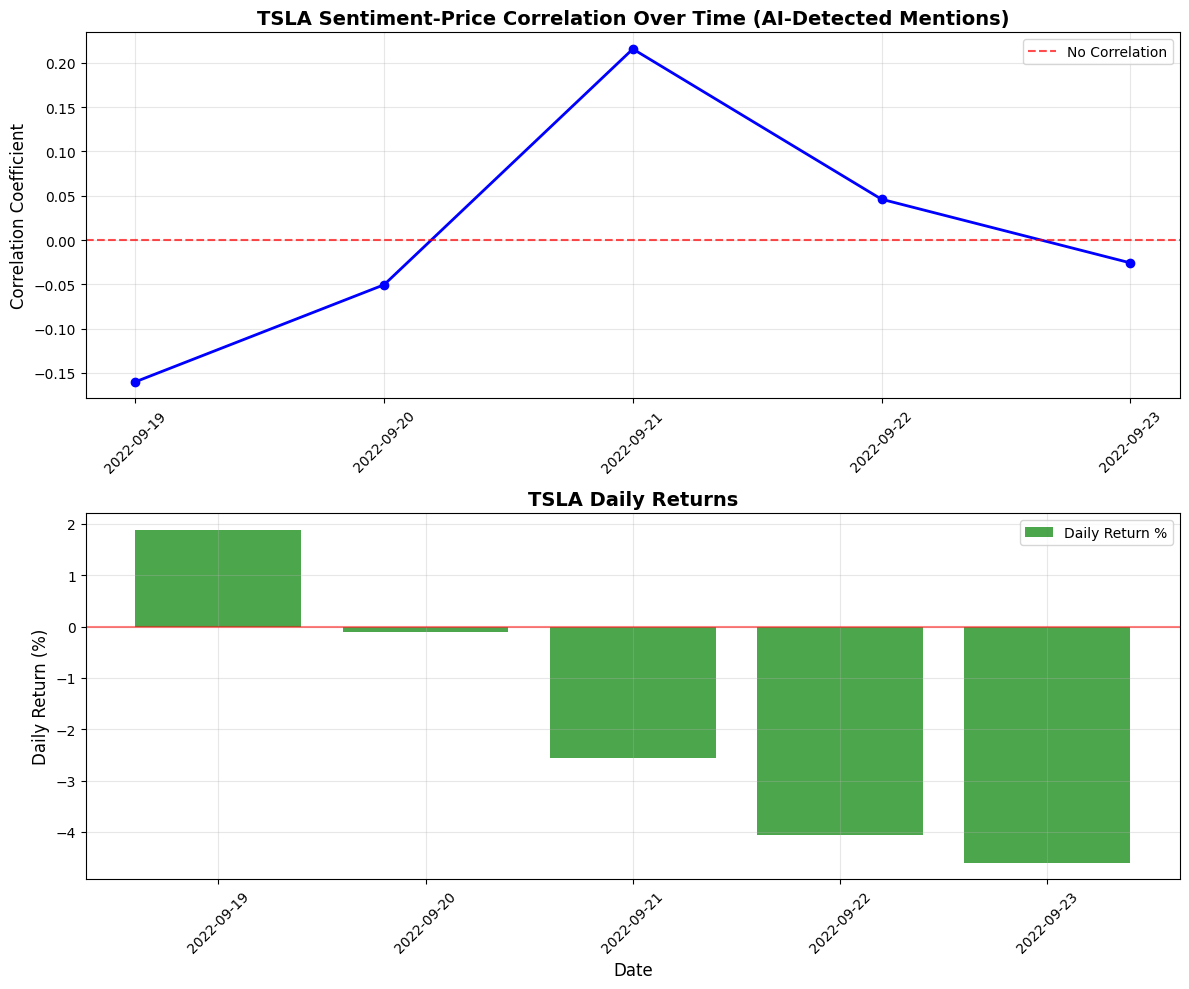


📊 TSLA Correlation Statistics:
   📈 Average Correlation: 0.005
   📊 Max Correlation: 0.216
   📉 Min Correlation: -0.160
   📅 Days Analyzed: 5
   ❓ Weak correlation between sentiment and price


In [46]:


tesla_results = plot_stock_correlation('TSLA',start_date='2022-09-19', num_days=5)


In [ ]:
# Example: Plot correlation for Apple starting from specific date
print("\n📊 APPLE CORRELATION ANALYSIS - SPECIFIC DATE RANGE")
print("=" * 60)

# Analyze Apple starting from a specific date
apple_results = plot_stock_correlation('AAPL', start_date='2022-09-29', num_days=7)


In [ ]:
# Example: Compare multiple stocks over same period
print("\n📊 MULTI-STOCK COMPARISON - SAME PERIOD")
print("=" * 60)

# Analyze multiple stocks over the same 7-day period
stocks_to_analyze = ['TSLA', 'AAPL', 'MSFT', 'GOOG', 'AMZN']
comparison_results = {}
start_date = '2022-09-29'  # Same start date for all stocks

for stock in stocks_to_analyze:
    print(f"\n🔍 Analyzing {stock} from {start_date}...")
    results = plot_stock_correlation(stock, start_date=start_date, num_days=7)
    if results:
        comparison_results[stock] = results['avg_correlation']

# Summary comparison
if comparison_results:
    print(f"\n📊 CORRELATION COMPARISON SUMMARY:")
    print("=" * 60)
    
    sorted_stocks = sorted(comparison_results.items(), key=lambda x: x[1], reverse=True)
    
    for stock, correlation in sorted_stocks:
        print(f"   {stock}: {correlation:.3f}")
    
    best_stock = sorted_stocks[0]
    worst_stock = sorted_stocks[-1]
    
    print(f"\n🏆 Best correlation: {best_stock[0]} ({best_stock[1]:.3f})")
    print(f"📉 Worst correlation: {worst_stock[0]} ({worst_stock[1]:.3f})")
